# Tema 3 - Compresia imaginilor cu JPEG

## Pachete utilizate

Pe lângă pachetele uzuale, [OpenCV](https://opencv.org/) este folosit pentru citirea și scrierea fișierelor video.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy import misc
from scipy.fft import dctn, idctn

import cv2

## Transformare DCT și cuantizare

Am aplicat algoritmul de compresie JPEG pe toate blocurile din imagine.

In [2]:
Q_jpeg = [
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 28, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
]

def process_image(image, q_matrix=Q_jpeg, print_stats=True):
    "Comprimă o imagine 2D cu un singur canal folosind algoritmul din standardul JPEG."

    # Alochez spațiu pentru rezultat
    result = np.zeros_like(image)

    if print_stats:
        # Rețin și câteva statistici
        nonzero_before = 0
        nonzero_after = 0
    
    # Parcurg imaginea inițială și aplic compresia cu DCT
    height, width = image.shape
    for i in range(height // 8):
        for j in range(width // 8):
            # Calculez indicii pe care se întinde blocul curent
            row_range = slice(i * 8, (i + 1) * 8)
            column_range = slice(j * 8, (j + 1) * 8)
            
            # Extrag blocul
            block = image[row_range, column_range]
            
            # Îl transform în domeniul frecvență
            freq_block = dctn(block)
            
            if print_stats:
                # Contorizez numărul de frecvențe nenule înainte de cuantizare
                nonzero_before += np.count_nonzero(freq_block)
                
            # Cuantizare
            compressed_freq_block = q_matrix * np.round(freq_block / q_matrix)
            
            if print_stats:
                # Contorizez numărul de frecvențe nenule după cuantizare
                nonzero_after += np.count_nonzero(compressed_freq_block)
            
            # Mă întorc în domeniul original
            compressed_block = idctn(compressed_freq_block)
            
            # Salvez rezultatul
            result[row_range, column_range] = compressed_block
    
    if print_stats:
        print('Componente în frecvență nenule înainte de compresie:', nonzero_before)
        print('Componente în frecvență nenule după compresie:', nonzero_after)
        compression_pct = nonzero_after/nonzero_before * 100
        print(f'Rată de compresie: {compression_pct:.2f}%')
    
    return result

Componente în frecvență nenule înainte de compresie: 250378
Componente în frecvență nenule după compresie: 125029
Rată de compresie: 49.94%


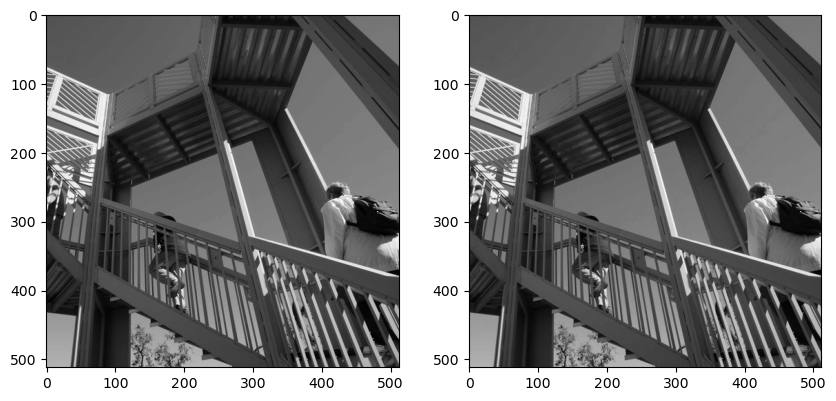

In [3]:
image = misc.ascent()
jpeg_image = process_image(image)

fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
ax[0].imshow(image, cmap='gray')
ax[1].imshow(jpeg_image, cmap='gray')
plt.show()

## Transformare $R G B \leftrightarrow Y C_B C_R$

Algoritmul de conversie este cel descris [pe Wikipedia](https://en.wikipedia.org/wiki/YCbCr), cu coeficienții bazați pe standardul **ITU-R BT.601**.

In [4]:
def rgb_to_ycbcr(image):
    "Descompune o imagine RGB în canale YCbCr"

    R = image[:, :, 0]
    G = image[:, :, 1]
    B = image[:, :, 2]
    
    Y = 16 + 65.738 * R / 256 + 129.057 * G / 256 + 25.064 * B / 256
    Cb = 128 - 37.945 * R / 256 - 74.494 * G / 256 + 112.439 * B / 256
    Cr = 128 + 112.439 * R / 256 - 94.154 * G / 256 - 18.285 * B / 256

    return Y, Cb, Cr

def ycbcr_to_rgb(Y, Cb, Cr):
    "Reconstruiește o imagine RGB din descompunere YCbCr"
    
    common = 298.082 * Y / 256
    
    R = common + 408.583 * Cr / 256 - 222.921
    R = R.round().astype(np.uint8)
    
    G = common - 100.291 * Cb / 256 - 208.120 * Cr / 256 + 135.576
    G = G.round().astype(np.uint8)
    
    B = common + 516.412 * Cb / 256 - 276.836
    B = B.round().astype(np.uint8)
    
    image = np.dstack((R, G, B))
    
    return image

def process_rgb_image(image, q_matrix=Q_jpeg):
    Y, Cb, Cr = rgb_to_ycbcr(image)
    
    Y = process_image(Y, q_matrix, print_stats=False)
    Cb = process_image(Cb, q_matrix, print_stats=False)
    Cr = process_image(Cr, q_matrix, print_stats=False)
    
    return ycbcr_to_rgb(Y, Cb, Cr)

def compute_image_mse(im1, im2):
    return np.mean((im1 - im2) ** 2)

Eroarea medie pătratică: 0.3152724372016059


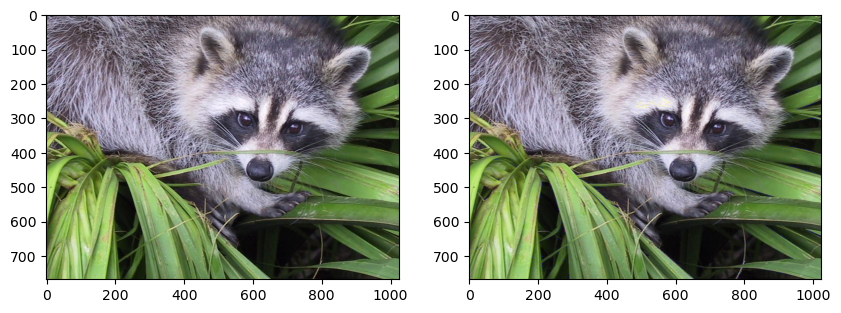

In [5]:
image = misc.face()
compressed = process_rgb_image(image)
print('Eroarea medie pătratică:', compute_image_mse(image, compressed))

fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
ax[0].imshow(image)
ax[1].imshow(compressed)
plt.show()

## Calitate ajustabilă

Putem obține calități diferite și rapoarte de compresie diferite ajustând matricea de cuantizare. Pentru a genera o matrice de cuantizare de calitate dată am adaptat o formulă [de pe StackOverflow](https://stackoverflow.com/a/29216609/5723188):

In [6]:
def compute_q_matrix(quality):
    "Calculează o matrice de cuantizare pentru o calitate dată."

    if not (0 < quality <= 100):
        raise Exception("Calitatea trebuie să fie în intervalul (0, 100]")

    if quality < 50:
        s = 5000 / quality
    else:
        s = 200 - 2 * quality

    Q_new = np.floor((s * np.array(Q_jpeg) + 50) / 100).astype(np.uint8)
    Q_new[Q_new == 0] = 1

    return Q_new

def process_rgb_image_with_quality(image, quality):
    "Comprimă o imagine cu algoritmul JPEG la calitatea cerută."
    q_matrix = compute_q_matrix(quality)
    return process_rgb_image(image, q_matrix)

def compute_mse_at_quality(image, quality):
    "Returnează eroarea MSE care s-ar obține dacă comprimăm imaginea la calitatea dată."
    compressed = process_rgb_image_with_quality(image, quality)
    return compute_image_mse(image, compressed)

## Comprimarea până la un prag MSE impus

Calitate 100 -- MSE: 0.0
Calitate 95 -- MSE: 0.020277659098307293
Calitate 90 -- MSE: 0.09650505913628472
Calitate 85 -- MSE: 0.14170667860243055
Calitate 80 -- MSE: 0.17187627156575522
Calitate 75 -- MSE: 0.1964806450737847
Calitate 70 -- MSE: 0.21699905395507812
Vom comprima la calitate 75


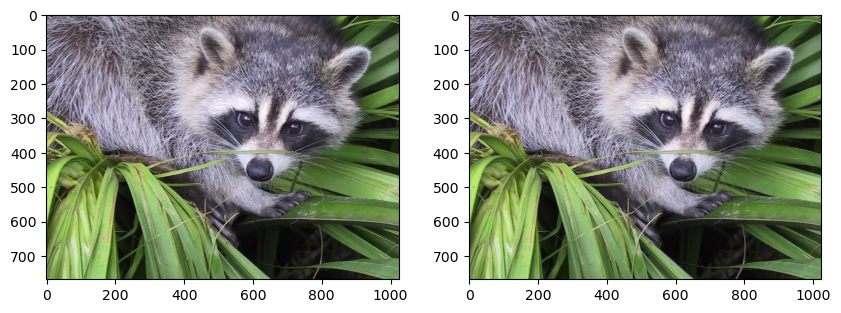

In [7]:
# Valoarea maximă permisă pentru eroarea medie pătratică
target_mse = 0.2

# Imaginea de intrare
image = misc.face()

# Pornesc cu calitatea maximă
quality = 100
last_quality = quality

while True:
    mse = compute_mse_at_quality(image, quality)
    print('Calitate', quality, '--', 'MSE:', mse)

    if mse > target_mse:
        break

    last_quality = quality
    # Scad câte 5 nivele
    quality -= 5

print('Vom comprima la calitate', last_quality)
    
compressed = process_rgb_image_with_quality(image, last_quality)
fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
ax[0].imshow(image)
ax[1].imshow(compressed)
plt.show()

## Compresie video

Video-ul ales este o reprezentare grafică a unei [funcții Bessel](https://en.wikipedia.org/wiki/Bessel_function).

In [8]:
cap = cv2.VideoCapture('bessel.mp4')

fourcc = cv2.VideoWriter_fourcc(*'VP90')
out = cv2.VideoWriter('compressed.webm', fourcc, 10, (360, 286))

num_frames = 0
while True:
    ret, frame = cap.read()

    if not ret:
        break

    print('Cadrul nr.', num_frames + 1, 'din 63', end='\r')
    
    # Imaginile primite sunt în format BGR
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Comprim cadrul
    compressed_frame = process_rgb_image_with_quality(frame, 95)

    # Imaginile salvate trebuie să fie în format BGR
    compressed_frame = cv2.cvtColor(compressed_frame, cv2.COLOR_RGB2BGR)
    out.write(compressed_frame)
    
    num_frames += 1

print()

cap.release()
out.release()

Cadrul nr. 63 din 63


In [9]:
from IPython.display import Video

Video('compressed.webm', html_attributes='controls loop')